In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression as LR
import sklearn.model_selection as ms
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import time
import matplotlib.pyplot as plt

# Preliminary Analisys

We import the League of Legends database, check for null values, and plot correlations in order to understand which features are more useful in order to predict Victory for Blue or Red team

In [3]:
df=pd.read_csv("/kaggle/input/match-data-v5-with-headers-csv/match_data_v5_with_column.csv")
df=df.drop(['Unnamed: 29'], axis=1).set_index("matchId")
print("Dataset contains {} NaN values".format(df.isnull().values.sum()))

Dataset contains 0 NaN values


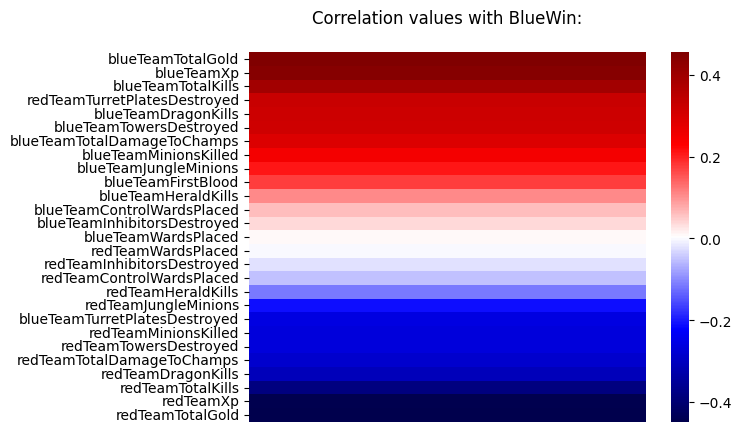

In [4]:
import seaborn as sns
corre = df.corr()[["blueWin"]].sort_values("blueWin", ascending = False)[1:]
sns.heatmap(corre, cmap="seismic", yticklabels= 1, xticklabels= 0).set_title("Correlation values with BlueWin:\n")
plt.show()

We checked for correlation in the dataset.
We examining the results and exclude immediately the features with low correlation. Knowing that the "minions", "jgl camps" and "kills" are variables which all only leads to advantage for "gold" ad "XP" columns, we further reduce the database

In [5]:
df=df[['blueTeamDragonKills', 'blueTeamTowersDestroyed',
       'blueTeamInhibitorsDestroyed', 'blueTeamTotalGold','blueTeamXp',
       'redTeamDragonKills', 'redTeamTowersDestroyed',
       'redTeamInhibitorsDestroyed','redTeamTotalGold','redTeamXp', 
       'blueTeamFirstBlood','blueWin']]

We can furthermore create a new database where we keep only the difference between the teams of the variables

In [ ]:
dfdiff=pd.DataFrame({f"{df.columns[x][8:]} Diff":df.iloc[:,x]-df.iloc[:,5+x] for x in range(5)}).assign(blueFirstBlood=df['blueTeamFirstBlood'],blueWin=df["blueWin"])
dfdiff.head()

In [59]:
first_blood_and_win=((df['blueTeamFirstBlood']==1) ^ (df["blueWin"]==0)).sum()
print(f"A curiosity: in only {round(first_blood_and_win/len(df) *100,2)}% of all matches the team which had first blood (i.e. the first kill which gives a little advantage mostly psycological) actually won the match")

A curiosity: in only 58.68% of all matches the team which had first blood (i.e. the first kill which gives a little advantage mostly psycological) actually won the match


I define a function which create train and test data, fit a given model with training data, evaluate accuracy on train and test data and measure processing time

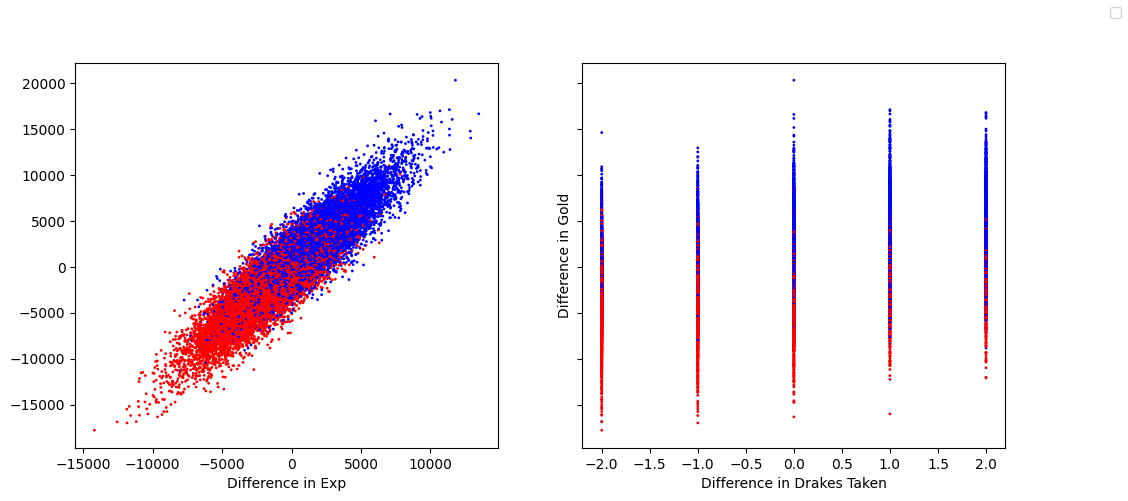

In [58]:
col = {0:"r", 1:"b"}
fig, ax = plt.subplots(1,2, sharey= True)
fig.set_size_inches(12,5)
scatter = ax[0].scatter(dfdiff["Xp Diff"],dfdiff["TotalGold Diff"],  c = dfdiff["blueWin"].apply(lambda x: col[x]), s=1)
ax[0].set_xlabel("Difference in Exp")
ax[1].scatter(dfdiff["DragonKills Diff"], dfdiff["TotalGold Diff"], c = dfdiff["blueWin"].apply(lambda x: col[x]), s=1)
ax[1].set_xlabel("Difference in Drakes Taken")
ax[1].set_ylabel("Difference in Gold")
fig.legend()

In [ ]:
def machine_learning(database, model_to_use, pca = False, use_scaler = False, print_tree=False):
    X = database.iloc[:,:-1]
    y = database.iloc[:,[-1]]
    Xtr, Xte, ytr, yte = ms.train_test_split(X,y, test_size=0.2)
    
    if use_scaler:
        scaler = preprocessing.StandardScaler()
        scaler=scaler.fit(Xtr)
        Xtr=scaler.transform(Xtr)
        Xte=scaler.transform(Xte)
        
    cv_score=ms.cross_val_score(model_to_use, X, y.values.ravel(), cv=5).mean()
    
    if pca != False:
        pca.fit(Xtr)
        Xtr=pca.transform(Xtr)
        Xte=pca.transform(Xte)
        
    t1 = time.time()
    modello=model_to_use
    modello=modello.fit(Xtr,ytr.values.ravel())
    y_pred_train =modello.predict(Xtr)
    score_train=accuracy_score(ytr, y_pred_train)
    t2 = time.time()
    y_pred_test = modello.predict(Xte)
    t3=time.time()
    score_test=accuracy_score(yte, y_pred_test)
    if print_tree:
        tree.plot_tree(modello, fontsize=7, feature_names=list(database.columns))
    print(f"""With {model_to_use}, Cross Validation gives average accuracy of {cv_score}.
          \naccuracy on train set {score_train}
          \naccuracy on test set {score_test}
          \nwith fitting time {t2-t1} and prediction time {t3-t2}""")
    

# First Model: Logistic regression

We normalize data and apply LR

In [ ]:
machine_learning(df,LR(), use_scaler=True)

In [ ]:
machine_learning(dfdiff,LR(), use_scaler=True)

# Second Model: Decision Trees

In [ ]:
from sklearn import tree
from sklearn.decomposition import PCA

machine_learning(dfdiff,tree.DecisionTreeClassifier(max_depth =4), print_tree=True)

In [ ]:
machine_learning(df,tree.DecisionTreeClassifier(max_depth =4), pca= PCA(n_components= 0.5))

In [ ]:
machine_learning(dfdiff,tree.DecisionTreeClassifier(max_depth =4), pca= PCA(n_components= 0.5))

# Improving Result

Could bagging or boosting improve performances? We'll test it out